## Contruction of Blocks in Example 2.1, Matthews & Taylor

### 0. Import libraries

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import operator as op
from functools import reduce
import time
from scipy import stats
import random as rnd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### 1. Data

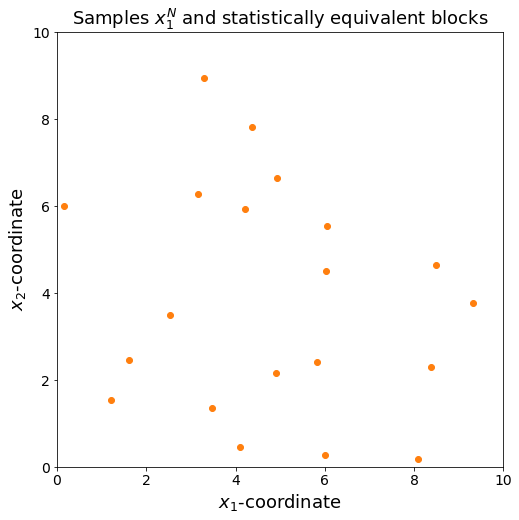

In [58]:
X = np.array([[4.91, 2.16], [6.05, 5.54], [3.48, 1.35], [8.09, 0.18], [2.53, 3.49],
             [1.62, 2.46], [8.37, 2.29], [3.17, 6.27], [6.02, 4.51], [8.50, 4.65],
             [4.21, 5.93], [0.15, 5.99], [9.31, 3.77], [4.10, 0.45], [5.83, 2.42],
             [6.00, 0.27], [3.30, 8.93], [4.38, 7.81], [4.93, 6.64], [1.22, 1.54]])

N = X.shape[0]

fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', label = 'Data', zorder = 1, ms = 6)

plt.xlabel(r'$x_1$-coordinate', fontsize = 18)
plt.ylabel(r'$x_2$-coordinate', fontsize = 18)
plt.title(r'Scatterplot of samples $x_1^N$', fontsize = 18)
plt.title(r'Samples $x_1^N$ and statistically equivalent blocks', fontsize = 18)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.grid()
#plt.legend(fontsize = 14)

#fig.savefig('SEB_example/SEB_samples.pdf', format='pdf', bbox_inches='tight')
fig.savefig('SEB_example/SEB_samples_2.png', format='png', bbox_inches='tight')


### 2. Cutting functions

In [3]:
# the class allow to define both cutting functions and permutations, in order to execute a bisection method or randomly
class CPfunctions():
    def __init__(self, 
                 Ndata, cut = None, perm = None):
        self.N = Ndata   # size of the data
    def permutation(self, random = False):
        """
        Define the permutation index for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        K = np.arange(1,N+1)
        new_K = []
        if random:
            np.random.shuffle(K)
            new_K = K
        else:
            k_first = list(K)
            k_first.sort()
            K_List = [k_first]
            K_marker = [0]  # index that says if the corresponding K_List has been partitioned or not

            for i in range(N):
                # choose list to divide
                for j in range(len(K_List)):
                    if K_marker[j] == 0 and len(K_List[j]) >= 1:
                        length_K = len(K_List[j])
                        # choose position of new_K in the list
                        K_position = (length_K+1)//2 -1   # the middle (even) or the first integer greater than the middle (odd)
                        new_K.append(K_List[j][K_position])
                        # split the existing array            
                        K_List.append(K_List[j][:K_position])
                        K_List.append(K_List[j][K_position+1:])
                        K_marker[j] = 1
                        K_marker.append(0)
                        K_marker.append(0)
                        # now add elements to H_new
                        break
                        
        self.perm = np.array(new_K)
        
    def cutting(self, random = False):
        """
        Define the cutting functions for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        H = np.random.randint(0, 2, N)
        K = self.perm
        new_H = H
        if not random:            
            H_counter = []   # counter to asign values of H
            h = 0
            while sum(H_counter) <= len(new_H):
                H_counter.append(2**h)
                h = h+1

            H_value = [0]*len(H_counter)    # values of H to asign
            for i in range(len(H_value)):
                if i%2 == 1:
                    H_value[i] = 1

            # for each element in K, asign the corresponding element in H

            for i in range(N):
                for m in range(len(H_value)):
                    if i+1 <= sum(H_counter[:m+1]):
                        new_H[K[i]-1] = H_value[m]
                        break
                        
        self.cut = np.array(new_H)

### 3. Partition: Class definition

### Let's define a class to work with the blocks

In [4]:
class block():
    def __init__(self, 
                 vertices = None, 
                 elements = None, 
                 stats = None, 
                 parent = None, 
                 leftChild = None, 
                 rightChild = None, 
                 prefChild = None):
        self.vertices = vertices   # array with 2 bidimensional elements, corresponding to the vertices of the block
                                   # vertices must be ordered starting from the left bottom vertix and finishing with the
                                   # right top vertix
                                   # the array must have two rows and two columns (bidimensional case)
        self.elements = elements   # array with the points that belong to the block. Each row contains an element and each
                                   # column is a dimension (in this case, bidimensional)
        self.stats = np.sort(stats) # array with index of blocks
        self.parent = parent       # parent of the block
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.prefChild = prefChild
    
    def plot(self, color = 'C0', lw = 1, size = 12, print_num = True):
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[0,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[1,0], self.vertices[:,1], color = color, lw = lw)
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[1,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[0,0], self.vertices[:,1], color = color, lw = lw)
        xplot = (self.vertices[0,0]+self.vertices[1,0])/2
        yplot = (self.vertices[0,1]+self.vertices[1,1])/2
        if self.stats.size == 1 and print_num:
            plt.text(xplot, yplot, str(self.stats[0]), fontsize = size)

        
    def split(self, axis, korder):
        """
        This method split a Block and creates two child blocks, making the partition on the korder th statistic
        axis: indicates wheter it is along the X axis (vertical, 0) or the Y axis (horizontal, 1)
        korder: is the order statistic to make the partition
        """
        # select the dimension to sort
        Xele = self.elements[:,axis]
        # select the kth order statistic
        Xorder = np.sort(Xele)
        minStat = min(self.stats)
        korder = korder - minStat
        xstat = Xorder[korder]
        # divide the stats
        statsL = self.stats[:korder+1]
        statsR = self.stats[korder+1:]
        # create the elements and vertices of each block
        Relements = np.empty((0, 2))
        Lelements = np.empty((0, 2))
        
        # add elements to vertices and elements for each case
        if axis == 0:
            Lvertices = np.array([self.vertices[0,:], [xstat, self.vertices[1,1]]])
            Rvertices = np.array([[xstat, self.vertices[0,1]], self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]  # chosen kth order 
        elif axis == 1:
            Lvertices = np.array([self.vertices[0,:], [self.vertices[1,0], xstat]])
            Rvertices = np.array([[self.vertices[0,0], xstat],self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]   # chosen kth order 
                
        # create the childs of the block
        Rchild = block(vertices = Rvertices, elements = Relements, stats = statsR, parent = self)  
        # right side or up side (the greaters elements)
        Lchild = block(vertices = Lvertices, elements = Lelements, stats = statsL, parent = self)   
        # left side or down side (the smaller elements)
        
        # asociate the childs to the parten
        self.rightChild = Rchild
        self.leftChild = Lchild
        self.prefChild = Pchild
        # return the place where the partition was made
        return xstat
    
    def belong(self, x):
        nx = x.shape[0]
        out = True
        for i in range(nx):
            out = out and self.vertices[0,i] < x[i] <= self.vertices[1,i]
        return out


### 4. Partition: general case
### We proceed to use the block class to apply the partition in an iterative loop

In [66]:
# define cutting functions and permutation order, blocks from data X
Lists_X = CPfunctions(N)
Lists_X.permutation()
Lists_X.cutting()
K_X = Lists_X.perm
H_X = Lists_X.cut
print(H_X[K_X-1])

# create list with blocks
First_Block = block(vertices = np.array([[-1,-1],[11,11]]), elements = X, stats = range(1,N+2))

Blocks_List = [First_Block]

step = 3

for i in range(step):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if K_X[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None:
            Blocks_List[j].split(axis = H_X[K_X[i]-1], korder = K_X[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])
            break

[0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0]


### Now we plot the finals blocks

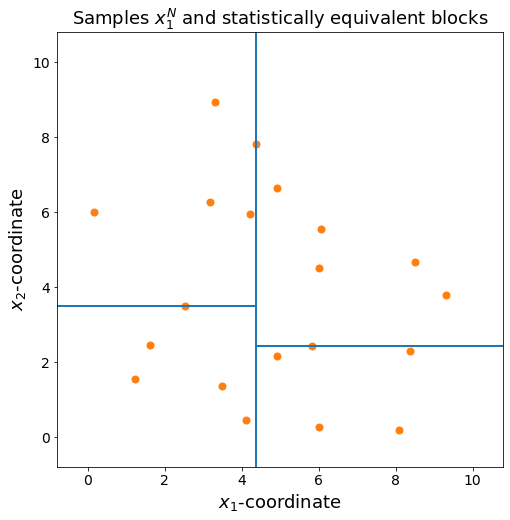

In [67]:
# plot
fig = plt.figure(figsize=(8,8))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot(print_num = False, lw=2)
        
plt.xlabel(r'$x_1$-coordinate', fontsize = 18)
plt.ylabel(r'$x_2$-coordinate', fontsize = 18)
plt.title(r'Samples $x_1^N$ and statistically equivalent blocks', fontsize = 18)
plt.xlim(-0.8,10.8)
plt.ylim(-0.8,10.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.grid()
#plt.legend(fontsize = 14)

#fig.savefig('SEB_example/SEB_samples_step0'+str(step)+'.pdf', format='pdf', bbox_inches='tight')
fig.savefig('SEB_example/Gif/SEB_samples_step0'+str(step)+'.png', format='png', bbox_inches='tight')

### Trying to create a gif

<ipython-input-72-f54a51baf637>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,8))


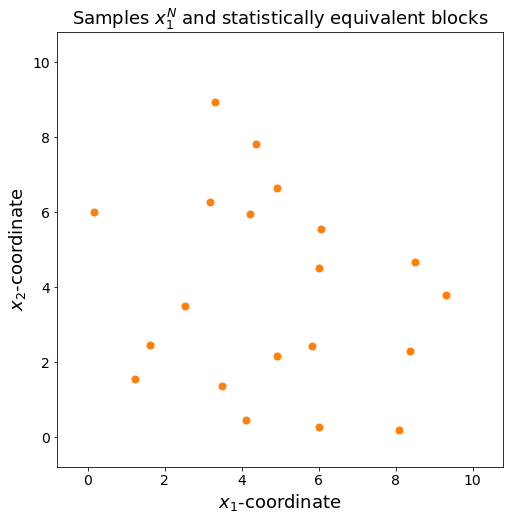

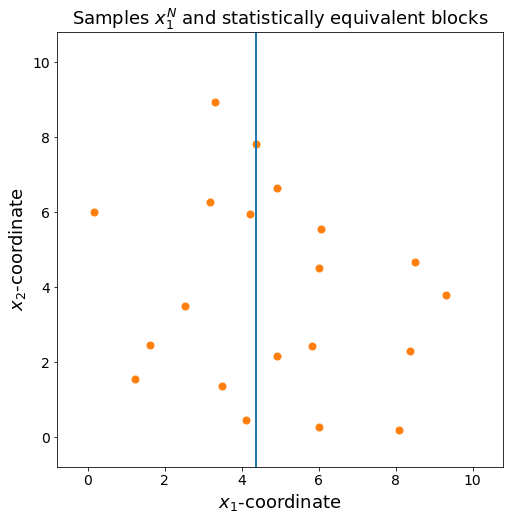

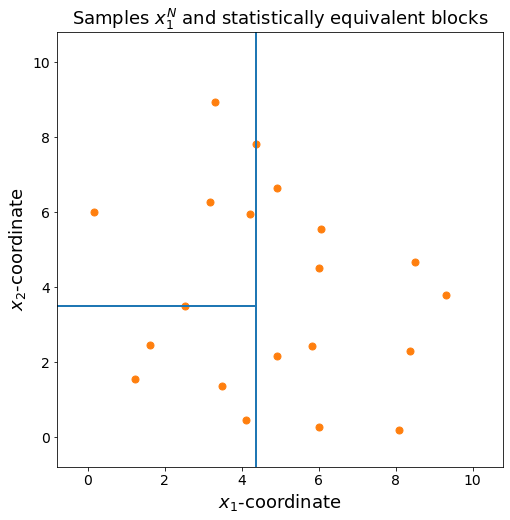

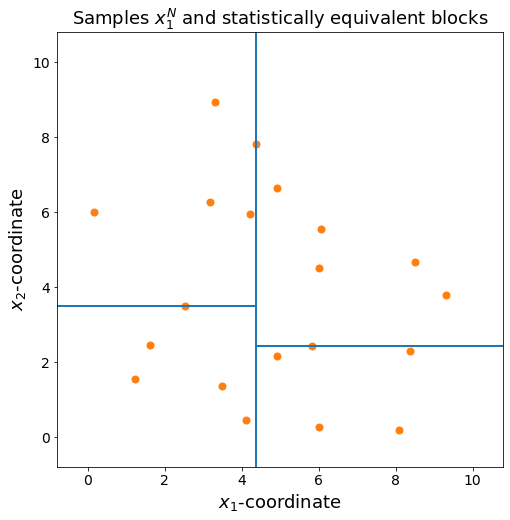

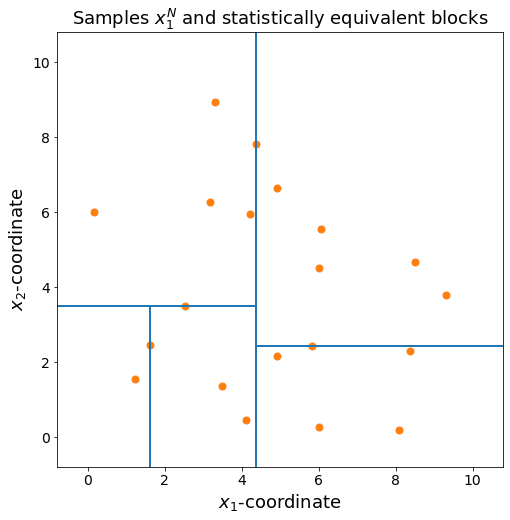

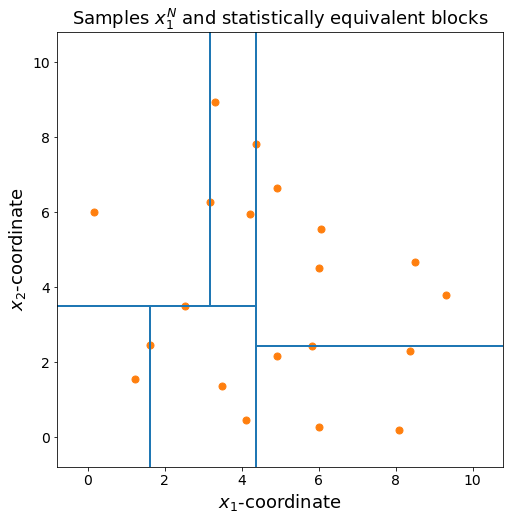

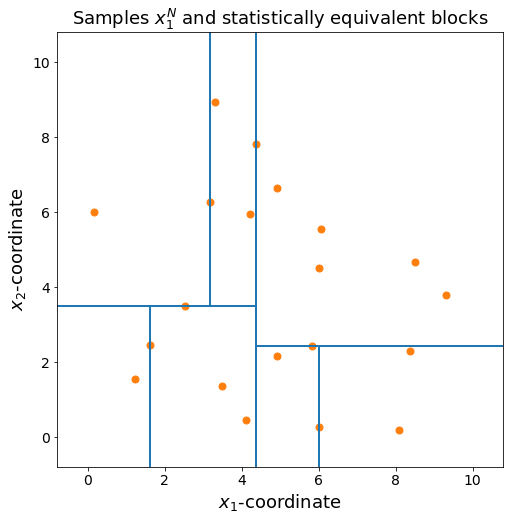

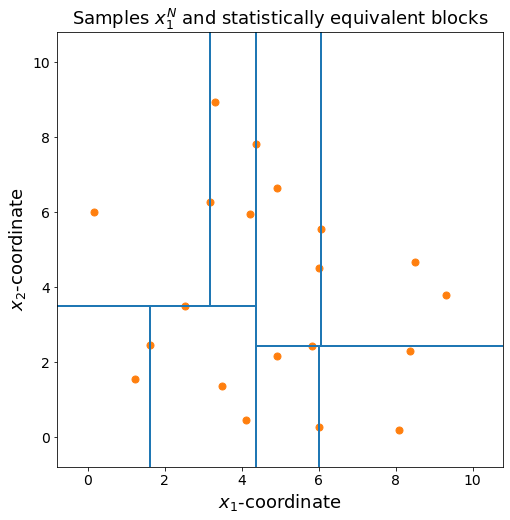

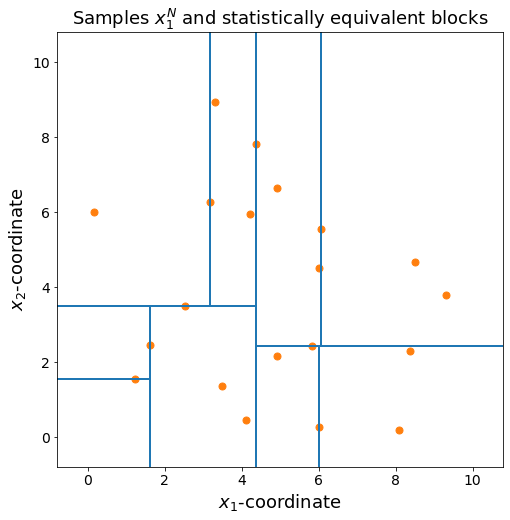

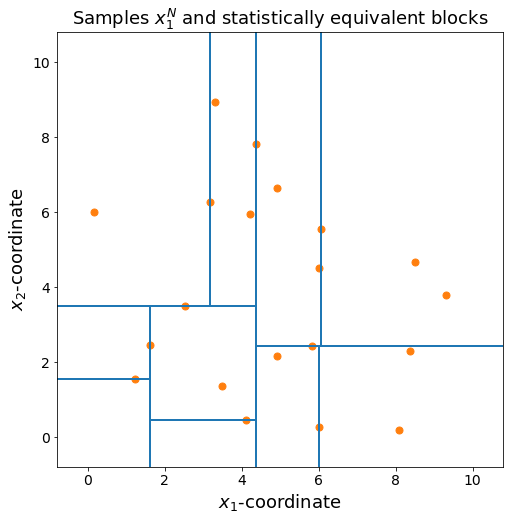

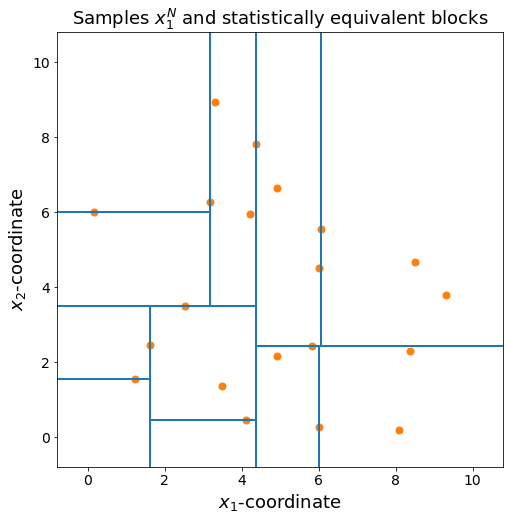

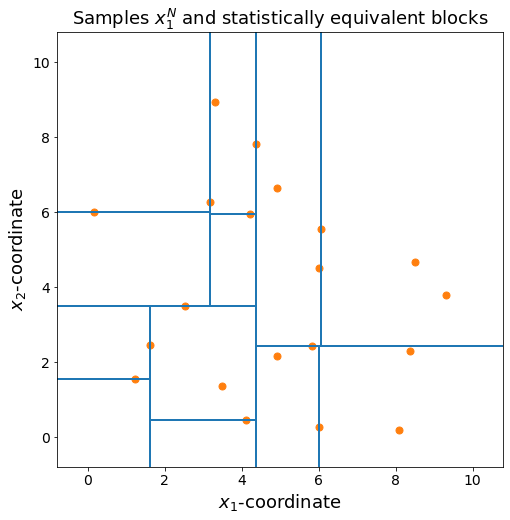

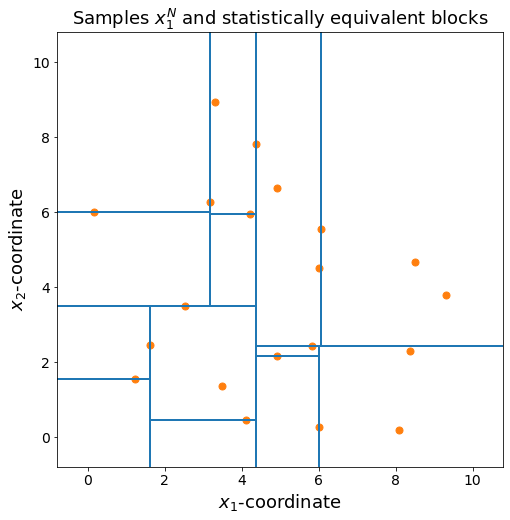

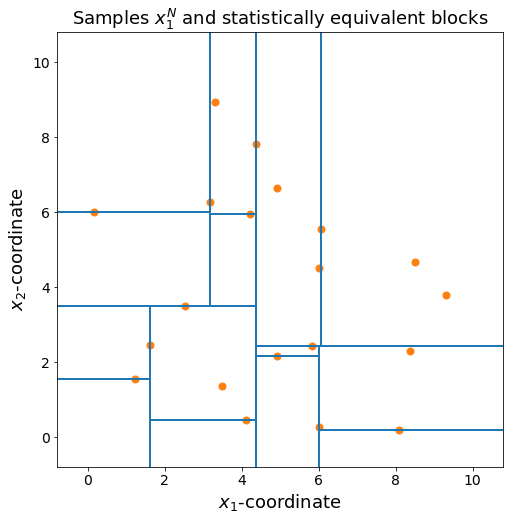

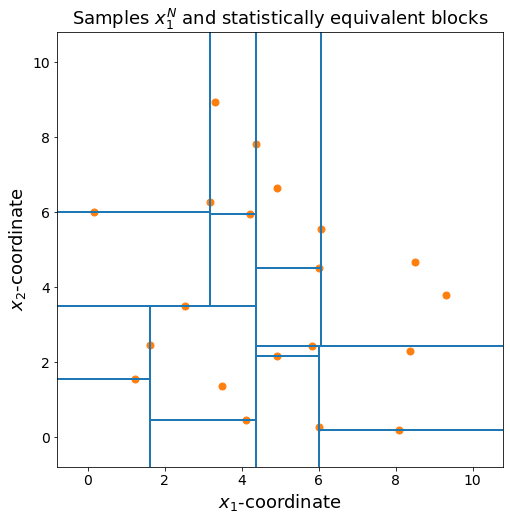

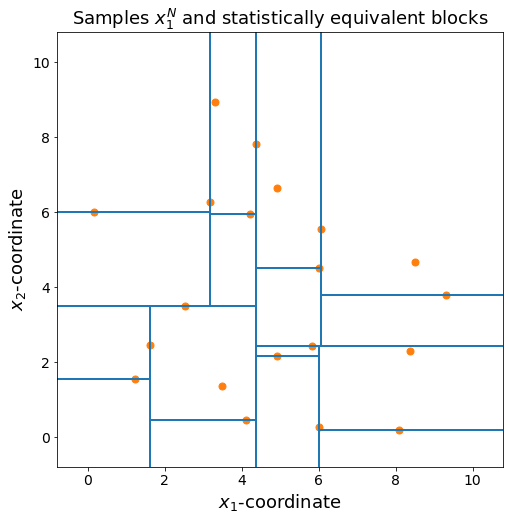

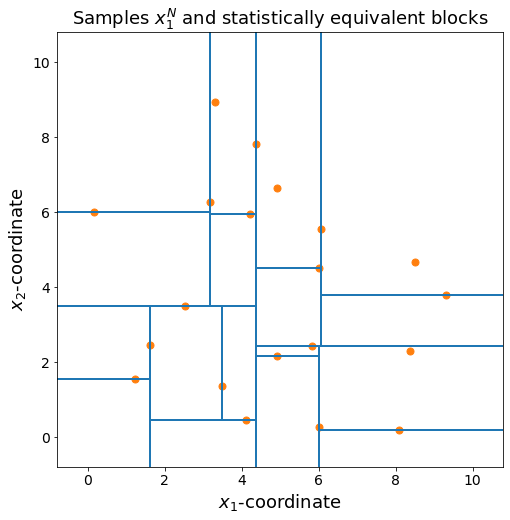

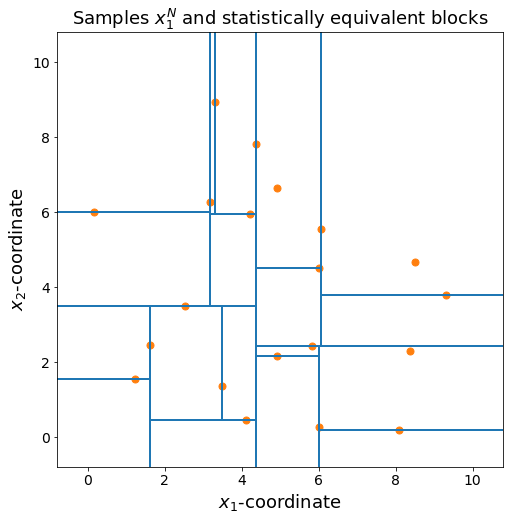

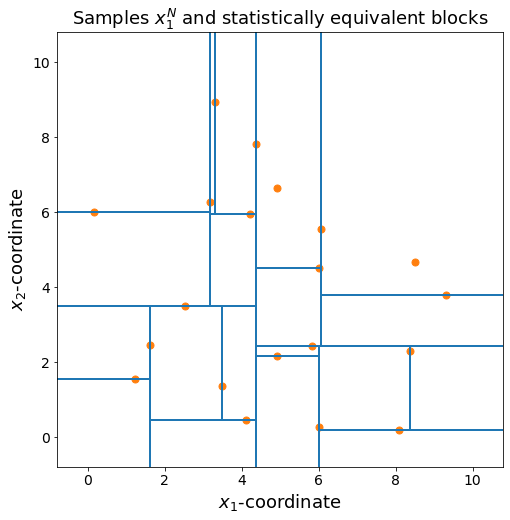

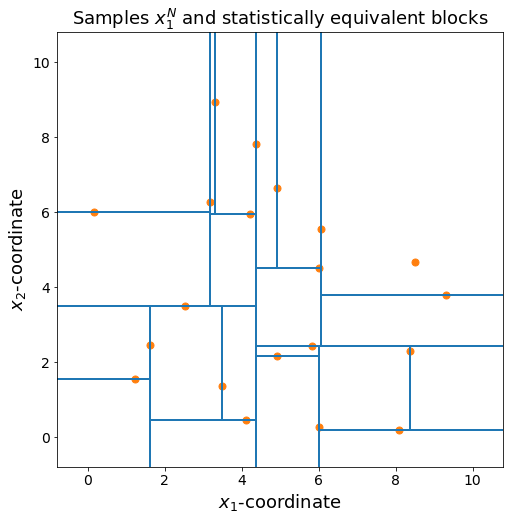

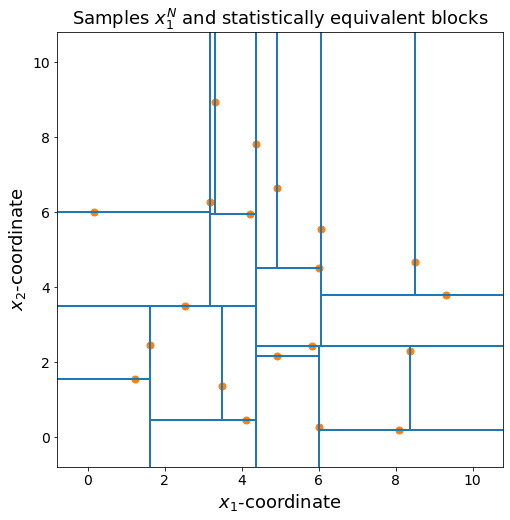

In [72]:
# create list with blocks

for step in range(N+1):
    
    First_Block = block(vertices = np.array([[-1,-1],[11,11]]), elements = X, stats = range(1,N+2))

    Blocks_List = [First_Block]

    for i in range(step):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List)):
            if K_X[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None:
                Blocks_List[j].split(axis = H_X[K_X[i]-1], korder = K_X[i])
                Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])
                break 

    # plot
    fig = plt.figure(figsize=(8,8))
    plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

    for j in range(len(Blocks_List)):
        if Blocks_List[j].leftChild == None:
            Blocks_List[j].plot(print_num = False, lw=2)

    plt.xlabel(r'$x_1$-coordinate', fontsize = 18)
    plt.ylabel(r'$x_2$-coordinate', fontsize = 18)
    plt.title(r'Samples $x_1^N$ and statistically equivalent blocks', fontsize = 18)
    plt.xlim(-0.8,10.8)
    plt.ylim(-0.8,10.8)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.grid()
    #plt.legend(fontsize = 14)
    
    if step < 10:
    #fig.savefig('SEB_example/SEB_samples_step0'+str(step)+'.pdf', format='pdf', bbox_inches='tight')
        fig.savefig('SEB_example/Gif/SEB_samples_step0'+str(step)+'.png', format='png', bbox_inches='tight')
    else:
        fig.savefig('SEB_example/Gif/SEB_samples_step'+str(step)+'.png', format='png', bbox_inches='tight')